<a href="https://colab.research.google.com/github/SilentClaw27/AdvancedRL/blob/main/lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
import time
import os
warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 5

In [3]:
env = gym.make('LunarLander-v2')

obs, info = env.reset()
episode_reward = 0.0

In [4]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():
  def __init__(self, env, fullsize, minsize, batchsize):
    self.env = env
    self.memory = deque(maxlen=fullsize)
    self.rewards = deque(maxlen=50)
    self.batchsize = batchsize
    self.minsize = minsize
  
  def append(self,transition):
    self.memory.append(transition)

  def sample_batch(self):
      batch = random.sample(self.memory, self.batchsize)
      batch = Transition(*zip(*batch))
      states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
      actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
      rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
      dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
      next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
      return states, actions, rewards, dones, next_states

  def initialize(self):
    obs, info = env.reset()
    for _ in range(self.minsize):
        action = self.env.action_space.sample()
        new_obs, reward, done, info = env.step(action)[:4]
        transition = Transition(obs, action, reward, done, new_obs)
        self.append(transition)
        obs = new_obs
        if done:
            self.env.reset()
    return self

In [5]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [6]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 64)
        self.a2 = nn.Linear(64, noutputs)
    
    def forward(self, X):
        o = self.a1(X)
        o = F.relu(o)
        o = self.a2(o)
        return o
    
    def __call__(self, X):
        return self.forward(X)

In [7]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [8]:
loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=0.001)

In [9]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

In [10]:
obs, info = env.reset()
eps_threshold =EPS_START
episode = 1
graph_results = []

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated,truncated, _ = env.step(action)
    replay_memory.append(Transition(obs, action, reward, terminated, new_obs))
    episode_reward += reward
    obs = new_obs
    
    if terminated or truncated:
        episode += 1
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        graph_results.append(episode_reward)

        obs,info = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 50 == 0: 
            avg_res = np.mean(replay_memory.rewards)
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195 :
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        
        if step % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

        episode_reward = 0

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)
    
    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode: 50 Avg Results: -135.87965047958258 Epsilon: 0.7822236754458713
Episode: 100 Avg Results: -69.57031347521337 Epsilon: 0.6088145090359074
Episode: 150 Avg Results: -36.60056696026939 Epsilon: 0.4738479773082268
Episode: 200 Avg Results: -14.910485722121864 Epsilon: 0.36880183088056995
Episode: 250 Avg Results: 12.234298977866274 Epsilon: 0.28704309604425327
Episode: 300 Avg Results: 61.763631970358965 Epsilon: 0.22340924607110255
Episode: 350 Avg Results: 73.68471548288885 Epsilon: 0.17388222158237718
Episode: 400 Avg Results: 147.5008240967596 Epsilon: 0.1353347165085562
Episode: 450 Avg Results: 137.31741602115878 Epsilon: 0.10533270926593409
Episode: 500 Avg Results: 151.05722419659259 Epsilon: 0.08198177029173696
Solved at episode: 533 Avg Results: 195.7826867634772


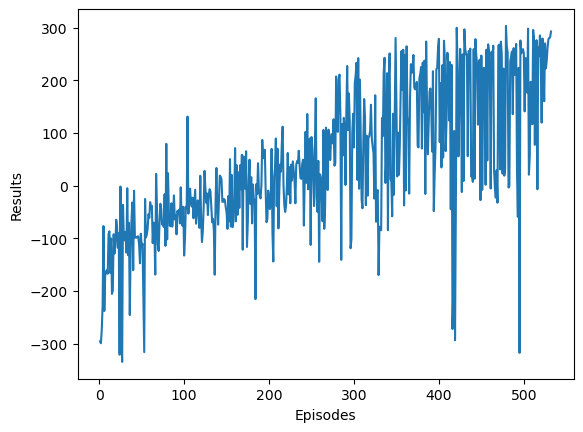

In [11]:
x = range(1,episode)
y = graph_results

plt.plot(x, y)
plt.xlabel('Episodes')
plt.ylabel('Results')
plt.show()